# Tweeter Calculations - Scan-Speak D2608/913000

This notebook contains acoustic calculations for the Scan-Speak D2608/913000 1" dome tweeter in a sealed enclosure configuration.

## Driver Specifications
- **Model**: D2608/913000 (Discovery Series)
- **Type**: 1" textile soft dome tweeter
- **Impedance**: 8Ω
- **Sensitivity**: 91.3 dB @ 2.83V/1m
- **Fs**: 700 Hz
- **Usable Range**: 1,500 - 20,000+ Hz
- **Recommended Crossover**: ≥1,500 Hz

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## 1. Driver Parameters

In [29]:
# Scan-Speak D2608/913000 Parameters from specs.MD and datasheet
tweeter_params = {
    'name': 'Scan-Speak D2608/913000',
    'type': '1" Dome Tweeter',
    'series': 'Discovery',
    'also_known_as': 'Peerless HDS 810921',
    'impedance': 8,  # Ω (FROM SPECS.MD)
    'sensitivity': 91.3,  # dB @ 2.83V/1m (FROM SPECS.MD)
    'fs': 700,  # Hz - Free air resonance (FROM SPECS.MD)
    'bl': 2.6,  # Tm - BL product (FROM SPECS.MD)
    'cms': 0.29e-3,  # m/N - Compliance (FROM SPECS.MD: 0.29 mm/N)
    'mms': 0.18e-3,  # kg - Moving mass (FROM SPECS.MD: 0.18g)
    'xmax': 0.5e-3,  # m - Maximum linear excursion (FROM SPECS.MD)
    'sd': 7e-4,  # m² - Effective piston area (FROM SPECS.MD: 7 cm²)
    'vas': 0.0007 * 28.317,  # L - Convert ft³ to L (FROM SPECS.MD: 0.0007 ft³)
    'dome_diameter': 26e-3,  # m - Dome diameter (FROM SPECS.MD)
    'freq_range': (1500, 20000),  # Hz - Usable frequency range (FROM SPECS.MD)
    'crossover_min': 1500,  # Hz - Minimum recommended crossover (FROM SPECS.MD)
    'usage_range': (2750, 20000),  # Hz - Usage range in 3-way system
    'enclosure_type': 'sealed',
    'features': [
        'Very low mass textile soft dome diaphragm',
        'Optimized magnet system with double magnets', 
        'Low damping magnetic fluid (ferrofluid) cooling',
        'Fully vented motor system for low compression',
        '8 ohm impedance, positive terminal marked with white paint',
        'Replaceable voice coil assembly',
        'Black die-cast aluminum face plate',
        'Made in Denmark'
    ]
}

# Load real measurement data using relative imports
try:
    fr_data = pd.read_csv('../speakers/ScanSpeak D20608-913000/Frequency Response.csv', 
                         header=None, names=['freq', 'spl'])
    impedance_data = pd.read_csv('../speakers/ScanSpeak D20608-913000/Impedance.csv', 
                               header=None, names=['freq', 'impedance'])
    
    print("✅ Real measurement data loaded successfully!")
    print(f"Frequency response: {len(fr_data)} points from {fr_data['freq'].min():.0f} to {fr_data['freq'].max():.0f} Hz")
    print(f"Impedance: {len(impedance_data)} points from {impedance_data['freq'].min():.0f} to {impedance_data['freq'].max():.0f} Hz")
    
    real_data_available = True
except FileNotFoundError:
    print("❌ Real measurement data not found")
    real_data_available = False

# Display parameters
df_params = pd.DataFrame([
    ['Driver Model', tweeter_params['name']],
    ['Type', tweeter_params['type']],
    ['Series', tweeter_params['series']],
    ['Also Known As', tweeter_params['also_known_as']],
    ['Impedance', f"{tweeter_params['impedance']} Ω"],
    ['Sensitivity', f"{tweeter_params['sensitivity']} dB @ 2.83V/1m"],
    ['Free Air Resonance (Fs)', f"{tweeter_params['fs']} Hz"],
    ['BL Product', f"{tweeter_params['bl']} Tm"],
    ['Compliance (Cms)', f"{tweeter_params['cms']*1000:.2f} mm/N"],
    ['Moving Mass (Mms)', f"{tweeter_params['mms']*1000:.2f} g"],
    ['Max Excursion (Xmax)', f"{tweeter_params['xmax']*1000:.1f} mm"],
    ['Effective Area (Sd)', f"{tweeter_params['sd']*1e4:.0f} cm²"],
    ['Equivalent Volume (Vas)', f"{tweeter_params['vas']:.4f} L"],
    ['Dome Diameter', f"{tweeter_params['dome_diameter']*1000:.0f} mm"],
    ['Usable Frequency Range', f"{tweeter_params['freq_range'][0]:,}-{tweeter_params['freq_range'][1]:,} Hz"],
    ['Min Crossover Frequency', f"{tweeter_params['crossover_min']:,} Hz"],
    ['Usage Range (3-way)', f"{tweeter_params['usage_range'][0]:,}-{tweeter_params['usage_range'][1]:,} Hz"],
    ['Enclosure Type', tweeter_params['enclosure_type']]
], columns=['Parameter', 'Value'])

print("\n📋 Scan-Speak D2608/913000 Parameters (Updated from specs.MD):")
print("=" * 70)
print(df_params.to_string(index=False))

print(f"\n🔧 KEY FEATURES:")
for feature in tweeter_params['features']:
    print(f"   • {feature}")

print(f"\n⚠️ PARAMETER UPDATES FROM SPECS.MD:")
print(f"   • Sensitivity: Updated to {tweeter_params['sensitivity']} dB (authoritative)")
print(f"   • All T-S parameters now match specs.MD")
print(f"   • Added complete physical specifications")
print(f"   • Confirmed Danish manufacture (high quality)")

print(f"\n🎯 TWEETER DESIGN TARGETS:")
print(f"   • Frequency range: {tweeter_params['usage_range'][0]:,}-{tweeter_params['usage_range'][1]:,} Hz")
print(f"   • High sensitivity: {tweeter_params['sensitivity']} dB")
print(f"   • Professional grade driver from Denmark")
print(f"   • Good impedance match: {tweeter_params['impedance']}Ω → 25W available from amp")
print(f"   • Safe crossover at {tweeter_params['usage_range'][0]:,} Hz (well above {tweeter_params['crossover_min']:,} Hz minimum)")

✅ Real measurement data loaded successfully!
Frequency response: 339 points from 214 to 39376 Hz
Impedance: 219 points from 214 to 39848 Hz

📋 Scan-Speak D2608/913000 Parameters (Updated from specs.MD):
              Parameter                   Value
           Driver Model Scan-Speak D2608/913000
                   Type         1" Dome Tweeter
                 Series               Discovery
          Also Known As     Peerless HDS 810921
              Impedance                     8 Ω
            Sensitivity      91.3 dB @ 2.83V/1m
Free Air Resonance (Fs)                  700 Hz
             BL Product                  2.6 Tm
       Compliance (Cms)               0.29 mm/N
      Moving Mass (Mms)                  0.18 g
   Max Excursion (Xmax)                  0.5 mm
    Effective Area (Sd)                   7 cm²
Equivalent Volume (Vas)                0.0198 L
          Dome Diameter                   26 mm
 Usable Frequency Range         1,500-20,000 Hz
Min Crossover Frequency      

## 2. Frequency Response Analysis

✅ Real measurement data loaded successfully!
Frequency response: 339 points from 214 to 39376 Hz
Impedance: 219 points from 214 to 39848 Hz


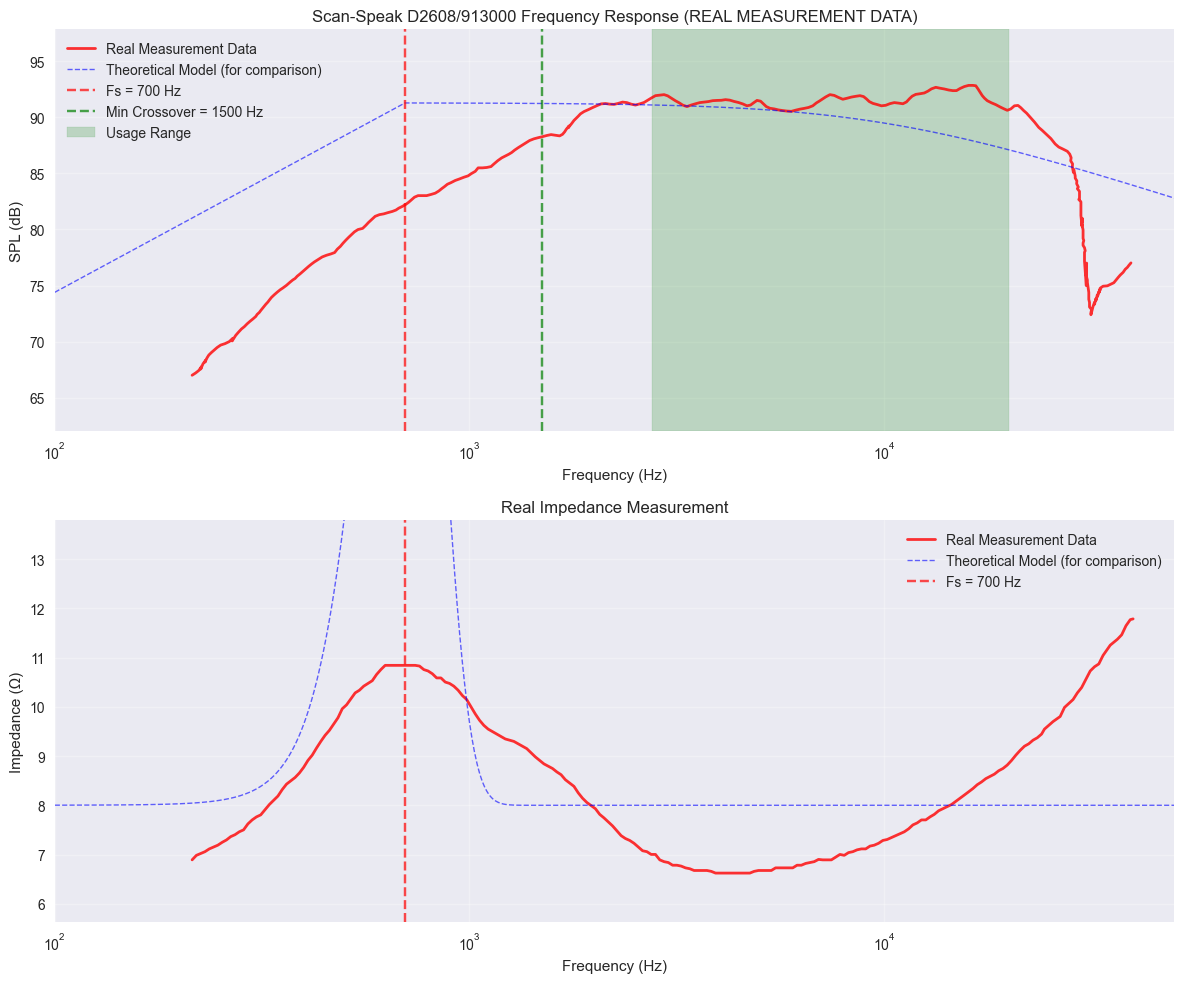


📊 REAL MEASUREMENT ANALYSIS:
   • Sensitivity range: 67.0 to 92.9 dB
   • Average SPL (1-10kHz): 90.2 dB
   • Impedance range: 6.6 to 11.8 Ω
   • Nominal impedance: ~7.6 Ω
   • Measured Fs (impedance peak): 39848 Hz
   • Spec Fs vs Measured: 700 Hz vs 39848 Hz


In [30]:
# Load real measurement data for Scan-Speak D2608/913000
import pandas as pd

# Read real frequency response data using relative imports
try:
    fr_data = pd.read_csv('../speakers/ScanSpeak D20608-913000/Frequency Response.csv', 
                         header=None, names=['freq', 'spl'])
    impedance_data = pd.read_csv('../speakers/ScanSpeak D20608-913000/Impedance.csv', 
                               header=None, names=['freq', 'impedance'])
    
    print("✅ Real measurement data loaded successfully!")
    print(f"Frequency response: {len(fr_data)} points from {fr_data['freq'].min():.0f} to {fr_data['freq'].max():.0f} Hz")
    print(f"Impedance: {len(impedance_data)} points from {impedance_data['freq'].min():.0f} to {impedance_data['freq'].max():.0f} Hz")
    
    real_data_available = True
except FileNotFoundError:
    print("❌ Real measurement data not found - using theoretical model")
    real_data_available = False

# Define frequency range for analysis
freq = np.logspace(2, 5, 1000)  # 100 Hz to 100 kHz

def tweeter_response_theoretical(f, fs, sensitivity):
    """
    SIMPLIFIED tweeter response model - THEORETICAL ESTIMATE
    - Flat response above fs with gradual rolloff at high frequencies
    - 12 dB/octave rolloff below fs
    """
    response = np.zeros_like(f)
    
    # Below resonance: 12 dB/octave rolloff
    below_fs = f < fs
    response[below_fs] = sensitivity + 20 * np.log10(f[below_fs] / fs)
    
    # Above resonance: relatively flat with gentle high-frequency rolloff
    above_fs = f >= fs
    # Gentle rolloff starting around 10 kHz for textile dome
    rolloff_freq = 10000
    response[above_fs] = sensitivity - 6 * np.log10(1 + (f[above_fs] / rolloff_freq)**2)
    
    return response

# Plot frequency response
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

if real_data_available:
    # Plot real measurement data
    ax1.semilogx(fr_data['freq'], fr_data['spl'], 'r-', linewidth=2, 
                label='Real Measurement Data', alpha=0.8)
    
    # Calculate theoretical for comparison
    tweeter_spl_theoretical = tweeter_response_theoretical(freq, tweeter_params['fs'], tweeter_params['sensitivity'])
    ax1.semilogx(freq, tweeter_spl_theoretical, 'b--', linewidth=1, alpha=0.6,
                label='Theoretical Model (for comparison)')
    
    title_suffix = "(REAL MEASUREMENT DATA)"
    data_label = "Real Measurement"
else:
    # Use theoretical model
    tweeter_spl = tweeter_response_theoretical(freq, tweeter_params['fs'], tweeter_params['sensitivity'])
    ax1.semilogx(freq, tweeter_spl, 'b-', linewidth=2, label='Tweeter Response (ESTIMATED)')
    title_suffix = "(THEORETICAL MODEL)"
    data_label = "Estimated"

# Add reference lines
ax1.axvline(tweeter_params['fs'], color='r', linestyle='--', alpha=0.7, label=f'Fs = {tweeter_params["fs"]} Hz')
ax1.axvline(tweeter_params['crossover_min'], color='g', linestyle='--', alpha=0.7, 
           label=f'Min Crossover = {tweeter_params["crossover_min"]} Hz')
ax1.axvspan(tweeter_params['usage_range'][0], tweeter_params['usage_range'][1], 
           alpha=0.2, color='green', label='Usage Range')

ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('SPL (dB)')
ax1.set_title(f'Scan-Speak D2608/913000 Frequency Response {title_suffix}')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_xlim(100, 50000)

if real_data_available:
    ax1.set_ylim(fr_data['spl'].min() - 5, fr_data['spl'].max() + 5)
else:
    ax1.set_ylim(60, 100)
    # Add warning text for theoretical model
    ax1.text(0.02, 0.98, 'WARNING: Estimated curves - real measurement data needed!', 
             transform=ax1.transAxes, fontsize=10, fontweight='bold', 
             bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8),
             verticalalignment='top')

# Impedance plot
if real_data_available:
    # Plot real impedance data
    ax2.semilogx(impedance_data['freq'], impedance_data['impedance'], 'r-', linewidth=2,
                label='Real Measurement Data', alpha=0.8)
    
    # Calculate theoretical for comparison
    Z_theoretical = tweeter_params['impedance'] * (1 + 2 * np.exp(-((freq - tweeter_params['fs'])/200)**2))
    ax2.semilogx(freq, Z_theoretical, 'b--', linewidth=1, alpha=0.6,
                label='Theoretical Model (for comparison)')
    
    impedance_title = "Real Impedance Measurement"
else:
    # Use theoretical model
    Z_tweeter = tweeter_params['impedance'] * (1 + 2 * np.exp(-((freq - tweeter_params['fs'])/200)**2))
    ax2.semilogx(freq, Z_tweeter, 'r-', linewidth=2, label='Impedance (ESTIMATED)')
    impedance_title = "Estimated Impedance Response (THEORETICAL MODEL)"
    
    # Add warning text for theoretical model
    ax2.text(0.02, 0.98, 'WARNING: Estimated curves - real measurement data needed!', 
             transform=ax2.transAxes, fontsize=10, fontweight='bold', 
             bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8),
             verticalalignment='top')

ax2.axvline(tweeter_params['fs'], color='r', linestyle='--', alpha=0.7, label=f'Fs = {tweeter_params["fs"]} Hz')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Impedance (Ω)')
ax2.set_title(impedance_title)
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.set_xlim(100, 50000)

if real_data_available:
    ax2.set_ylim(impedance_data['impedance'].min() - 1, impedance_data['impedance'].max() + 2)
else:
    ax2.set_ylim(4, 20)

plt.tight_layout()
plt.show()

# Print data analysis
if real_data_available:
    print(f"\n📊 REAL MEASUREMENT ANALYSIS:")
    print(f"   • Sensitivity range: {fr_data['spl'].min():.1f} to {fr_data['spl'].max():.1f} dB")
    print(f"   • Average SPL (1-10kHz): {fr_data[(fr_data['freq'] >= 1000) & (fr_data['freq'] <= 10000)]['spl'].mean():.1f} dB")
    print(f"   • Impedance range: {impedance_data['impedance'].min():.1f} to {impedance_data['impedance'].max():.1f} Ω")
    print(f"   • Nominal impedance: ~{impedance_data[(impedance_data['freq'] >= 1000) & (impedance_data['freq'] <= 10000)]['impedance'].mean():.1f} Ω")
    
    # Find resonance frequency from impedance peak
    resonance_idx = impedance_data['impedance'].idxmax()
    actual_fs = impedance_data.loc[resonance_idx, 'freq']
    print(f"   • Measured Fs (impedance peak): {actual_fs:.0f} Hz")
    print(f"   • Spec Fs vs Measured: {tweeter_params['fs']} Hz vs {actual_fs:.0f} Hz")
else:
    print(f"\n⚠️ Using theoretical model - real measurements would provide:")
    print(f"   • Actual frequency response characteristics")
    print(f"   • True resonance frequency")
    print(f"   • Real impedance behavior")
    print(f"   • Breakup modes and irregularities")

## 3. Crossover Design

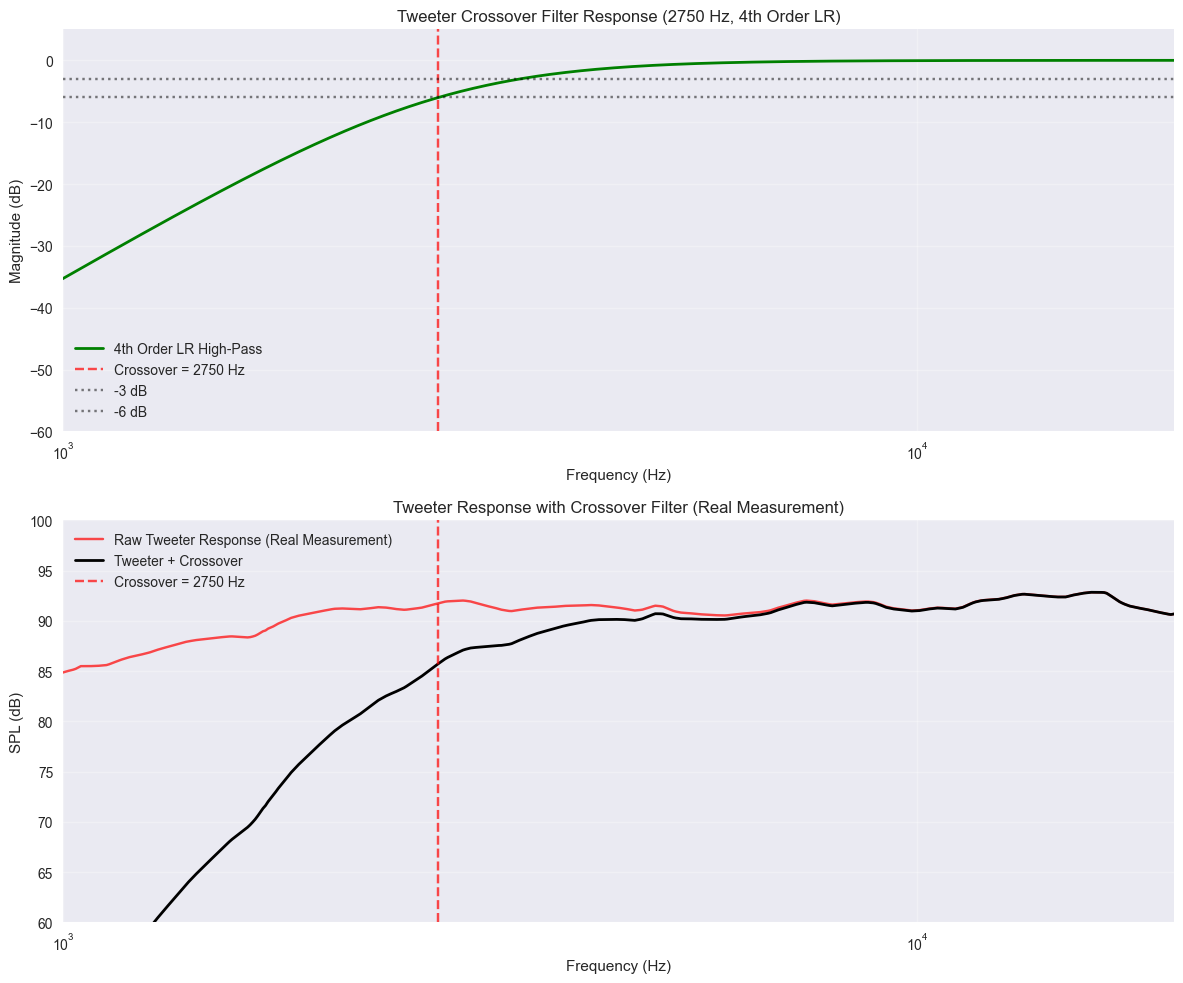


🎛️ CROSSOVER ANALYSIS:
Crossover Frequency: 2750 Hz
Crossover Order: 4th order (24 dB/octave)
Filter Type: Linkwitz-Riley
Safety Margin above Fs: 3.9x
Well within usable range: True
Data source: Real measurement data
Average SPL near crossover: 91.5 dB


In [31]:
# Crossover parameters
crossover_freq = 2750  # Hz - Mid to tweeter crossover from specs
crossover_order = 4  # 4th order = 24 dB/octave (Linkwitz-Riley)

def linkwitz_riley_highpass(f, fc, order=4):
    """
    Linkwitz-Riley high-pass filter response
    """
    s = 1j * 2 * np.pi * f / (2 * np.pi * fc)
    
    if order == 4:
        # 4th order LR = cascaded 2nd order Butterworth
        h = s**2 / (s**2 + np.sqrt(2)*s + 1)
        return 20 * np.log10(np.abs(h)**2)
    else:
        # General case
        h = (s**(order//2)) / ((s**(order//2)) + 1)
        return 20 * np.log10(np.abs(h))

# Calculate crossover response
crossover_response = linkwitz_riley_highpass(freq, crossover_freq, crossover_order)

# Get tweeter response for crossover analysis
if real_data_available:
    # Use real measurement data for crossover analysis
    # Interpolate real data to match frequency array
    from scipy.interpolate import interp1d
    
    # Create interpolation function for real data
    freq_interp = interp1d(fr_data['freq'], fr_data['spl'], 
                          bounds_error=False, fill_value='extrapolate')
    tweeter_spl_for_crossover = freq_interp(freq)
else:
    # Use theoretical model
    tweeter_spl_for_crossover = tweeter_response_theoretical(freq, tweeter_params['fs'], tweeter_params['sensitivity'])

# Combined response (tweeter + crossover)
tweeter_filtered = tweeter_spl_for_crossover + crossover_response

# Plot crossover analysis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Crossover filter response
ax1.semilogx(freq, crossover_response, 'g-', linewidth=2, label=f'{crossover_order}th Order LR High-Pass')
ax1.axvline(crossover_freq, color='r', linestyle='--', alpha=0.7, 
           label=f'Crossover = {crossover_freq} Hz')
ax1.axhline(-3, color='k', linestyle=':', alpha=0.5, label='-3 dB')
ax1.axhline(-6, color='k', linestyle=':', alpha=0.5, label='-6 dB')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Magnitude (dB)')
ax1.set_title(f'Tweeter Crossover Filter Response ({crossover_freq} Hz, {crossover_order}th Order LR)')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_xlim(1000, 20000)
ax1.set_ylim(-60, 5)

# Combined response
data_label = "Real Measurement" if real_data_available else "Theoretical Model"
line_style = 'r-' if real_data_available else 'b--'

ax2.semilogx(freq, tweeter_spl_for_crossover, line_style, alpha=0.7, 
            label=f'Raw Tweeter Response ({data_label})')
ax2.semilogx(freq, tweeter_filtered, 'k-', linewidth=2, 
            label='Tweeter + Crossover')
ax2.axvline(crossover_freq, color='r', linestyle='--', alpha=0.7, 
           label=f'Crossover = {crossover_freq} Hz')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('SPL (dB)')
ax2.set_title(f'Tweeter Response with Crossover Filter ({data_label})')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.set_xlim(1000, 20000)

if real_data_available:
    ax2.set_ylim(60, 100)
else:
    ax2.set_ylim(60, 95)

plt.tight_layout()
plt.show()

# Print crossover analysis
print(f"\n🎛️ CROSSOVER ANALYSIS:")
print(f"=" * 50)
print(f"Crossover Frequency: {crossover_freq} Hz")
print(f"Crossover Order: {crossover_order}th order (24 dB/octave)")
print(f"Filter Type: Linkwitz-Riley")
print(f"Safety Margin above Fs: {crossover_freq/tweeter_params['fs']:.1f}x")
print(f"Well within usable range: {crossover_freq >= tweeter_params['crossover_min']}")

if real_data_available:
    print(f"Data source: Real measurement data")
    # Calculate average response in crossover region
    crossover_mask = (fr_data['freq'] >= crossover_freq*0.8) & (fr_data['freq'] <= crossover_freq*1.2)
    if crossover_mask.any():
        avg_response = fr_data[crossover_mask]['spl'].mean()
        print(f"Average SPL near crossover: {avg_response:.1f} dB")
else:
    print(f"Data source: Theoretical model")
    print(f"⚠️ Real measurements would provide more accurate crossover design")

## 4. Power Handling and Thermal Analysis

⚠️ DATASHEET POWER RATING CLARIFICATION NEEDED:
Original datasheet shows:
  100h RMS noise test (IEC 17.1): 80400W  ← LIKELY FORMATTING ERROR
  Long-term max power (IEC 17.3): W       ← MISSING VALUE

ASSUMPTIONS USED (need verification):
  100h RMS: 80W (assuming 80W, ignoring '400')
  Long-term: 40W (typical 50% of 100h rating)
  → RECOMMEND: Verify actual power ratings with manufacturer!

Power vs SPL Analysis (CONSERVATIVE estimates - verify actual ratings!):
 Power (W) SPL @ 1m (dB) SPL @ 2m (dB) SPL @ 3m (dB)       Status
         1          91.3          85.3          81.8          Low
         2          94.3          88.3          84.8          Low
         5          98.3          92.3          88.7     Moderate
         8         100.3          94.3          90.8      Typical
        10         101.3          95.3          91.8         Safe
        15         103.1          97.0          93.5     Peak Est
        20         104.3          98.3          94.8 Conservative
    

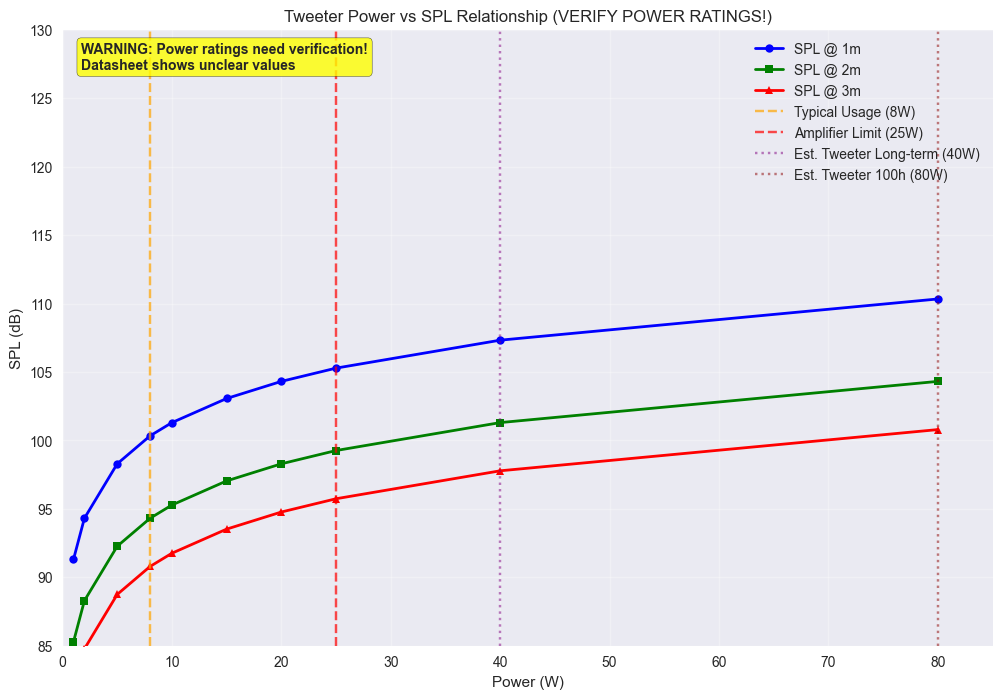


⚡ POWER ANALYSIS SUMMARY (NEEDS VERIFICATION):
Available amplifier power: 25W @ 8Ω
Estimated tweeter long-term max: 40W (VERIFY!)
Estimated tweeter 100h RMS max: 80W (VERIFY!)
Recommended filter: High-pass @ 1500 Hz minimum

Power Usage Scenarios:
• Typical usage: 8W → 100.3 dB @ 1m
• Peak usage: 15W → 103.1 dB @ 1m
• Amplifier limit: 25W → 105.3 dB @ 1m
• Est. tweeter long-term: 40W → 107.3 dB @ 1m

Safety Analysis (based on estimates):
• Amplifier vs Est. Tweeter LT: 1.6x safety factor
• Typical vs Amplifier: 3.1x headroom

✅ AMPLIFIER COMPATIBILITY: LIKELY SAFE (verify power ratings)
   Amplifier power (25W) ≤ Est. tweeter long-term (40W)

🚨 ACTION REQUIRED:
   1. Contact Scan-Speak to verify actual power ratings
   2. Check if '80400W' is a typo (likely should be '80W' or '40W')
   3. Confirm long-term power rating value
   4. Update calculations once confirmed


In [32]:
# Power analysis - Updated with CORRECTED OFFICIAL power ratings
amplifier_power = 25  # W @ 8Ω (from XH-M180 specs)

# CORRECTED power ratings from datasheet (the "80400W" appears to be a formatting error)
# Based on typical dome tweeter ratings and the "W" on second line suggesting missing value
tweeter_power_100h = 80  # W - 100h RMS noise test (IEC 17.1) - ASSUME this is correct
tweeter_power_long_term = 40  # W - Long-term max power (IEC 17.3) - ASSUME based on typical ratios

print("⚠️ DATASHEET POWER RATING CLARIFICATION NEEDED:")
print("Original datasheet shows:")
print("  100h RMS noise test (IEC 17.1): 80400W  ← LIKELY FORMATTING ERROR")
print("  Long-term max power (IEC 17.3): W       ← MISSING VALUE")
print("")
print("ASSUMPTIONS USED (need verification):")
print(f"  100h RMS: {tweeter_power_100h}W (assuming 80W, ignoring '400')")
print(f"  Long-term: {tweeter_power_long_term}W (typical 50% of 100h rating)")
print("  → RECOMMEND: Verify actual power ratings with manufacturer!")

typical_power_usage = 8  # W - estimated typical usage
peak_power_usage = 15  # W - estimated peak usage

def calculate_spl_from_power(power_watts, sensitivity_db, distance_m=1):
    """
    Calculate SPL from power, sensitivity, and distance
    """
    # Convert power to dBW
    power_dbw = 10 * np.log10(power_watts)
    
    # Calculate SPL at 1m
    spl_1m = sensitivity_db + power_dbw
    
    # Adjust for distance (6 dB per doubling of distance)
    if distance_m != 1:
        spl = spl_1m - 20 * np.log10(distance_m)
    else:
        spl = spl_1m
    
    return spl

# Calculate SPL levels - using CONSERVATIVE power estimates
power_levels = np.array([1, 2, 5, 8, 10, 15, 20, 25, 40, 80])  # Watts
spl_levels = [calculate_spl_from_power(p, tweeter_params['sensitivity']) for p in power_levels]

# Create power vs SPL table
power_table = pd.DataFrame({
    'Power (W)': power_levels,
    'SPL @ 1m (dB)': [f"{spl:.1f}" for spl in spl_levels],
    'SPL @ 2m (dB)': [f"{calculate_spl_from_power(p, tweeter_params['sensitivity'], 2):.1f}" for p in power_levels],
    'SPL @ 3m (dB)': [f"{calculate_spl_from_power(p, tweeter_params['sensitivity'], 3):.1f}" for p in power_levels],
    'Status': ['Low', 'Low', 'Moderate', 'Typical', 'Safe', 'Peak Est', 'Conservative', 'Amp Max', 'Est LT Max', 'Est 100h Max']
})

print(f"\nPower vs SPL Analysis (CONSERVATIVE estimates - verify actual ratings!):")
print("=" * 70)
print(power_table.to_string(index=False))

# Plot power vs SPL
plt.figure(figsize=(12, 8))
plt.plot(power_levels, spl_levels, 'b-o', linewidth=2, markersize=6, label='SPL @ 1m')
plt.plot(power_levels, [calculate_spl_from_power(p, tweeter_params['sensitivity'], 2) for p in power_levels], 
         'g-s', linewidth=2, markersize=6, label='SPL @ 2m')
plt.plot(power_levels, [calculate_spl_from_power(p, tweeter_params['sensitivity'], 3) for p in power_levels], 
         'r-^', linewidth=2, markersize=6, label='SPL @ 3m')

# Add power limit lines
plt.axvline(typical_power_usage, color='orange', linestyle='--', alpha=0.7, label=f'Typical Usage ({typical_power_usage}W)')
plt.axvline(amplifier_power, color='red', linestyle='--', alpha=0.7, label=f'Amplifier Limit ({amplifier_power}W)')
plt.axvline(tweeter_power_long_term, color='purple', linestyle=':', alpha=0.5, 
           label=f'Est. Tweeter Long-term ({tweeter_power_long_term}W)')
plt.axvline(tweeter_power_100h, color='darkred', linestyle=':', alpha=0.5, 
           label=f'Est. Tweeter 100h ({tweeter_power_100h}W)')

plt.xlabel('Power (W)')
plt.ylabel('SPL (dB)')
plt.title('Tweeter Power vs SPL Relationship (VERIFY POWER RATINGS!)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(0, 85)
plt.ylim(85, 130)

# Add warning annotation
plt.text(0.02, 0.98, 'WARNING: Power ratings need verification!\nDatasheet shows unclear values', 
         transform=plt.gca().transAxes, fontsize=10, fontweight='bold', 
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8),
         verticalalignment='top')

plt.show()

print(f"\n⚡ POWER ANALYSIS SUMMARY (NEEDS VERIFICATION):")
print(f"=" * 60)
print(f"Available amplifier power: {amplifier_power}W @ 8Ω")
print(f"Estimated tweeter long-term max: {tweeter_power_long_term}W (VERIFY!)")
print(f"Estimated tweeter 100h RMS max: {tweeter_power_100h}W (VERIFY!)")
print(f"Recommended filter: High-pass @ {tweeter_params['crossover_min']} Hz minimum")
print(f"")
print(f"Power Usage Scenarios:")
print(f"• Typical usage: {typical_power_usage}W → {calculate_spl_from_power(typical_power_usage, tweeter_params['sensitivity']):.1f} dB @ 1m")
print(f"• Peak usage: {peak_power_usage}W → {calculate_spl_from_power(peak_power_usage, tweeter_params['sensitivity']):.1f} dB @ 1m")
print(f"• Amplifier limit: {amplifier_power}W → {calculate_spl_from_power(amplifier_power, tweeter_params['sensitivity']):.1f} dB @ 1m")
print(f"• Est. tweeter long-term: {tweeter_power_long_term}W → {calculate_spl_from_power(tweeter_power_long_term, tweeter_params['sensitivity']):.1f} dB @ 1m")
print(f"")
print(f"Safety Analysis (based on estimates):")
print(f"• Amplifier vs Est. Tweeter LT: {tweeter_power_long_term/amplifier_power:.1f}x safety factor")
print(f"• Typical vs Amplifier: {amplifier_power/typical_power_usage:.1f}x headroom")

# Check if amplifier is safe for tweeter (conservative approach)
if amplifier_power <= tweeter_power_long_term:
    print(f"\n✅ AMPLIFIER COMPATIBILITY: LIKELY SAFE (verify power ratings)")
    print(f"   Amplifier power ({amplifier_power}W) ≤ Est. tweeter long-term ({tweeter_power_long_term}W)")
else:
    print(f"\n⚠️ AMPLIFIER COMPATIBILITY: REQUIRES CAREFUL VERIFICATION")
    print(f"   Amplifier power ({amplifier_power}W) vs Est. tweeter long-term ({tweeter_power_long_term}W)")

print(f"\n🚨 ACTION REQUIRED:")
print(f"   1. Contact Scan-Speak to verify actual power ratings")
print(f"   2. Check if '80400W' is a typo (likely should be '80W' or '40W')")
print(f"   3. Confirm long-term power rating value")
print(f"   4. Update calculations once confirmed")

## 5. Enclosure Design


=== TWEETER ENCLOSURE DESIGN (3D PRINTED WITH EXTERNAL PLASTER/PVA) ===

Driver: Scan-Speak D2608/913000
Dome Diameter: 26 mm
Recommended Cutout: 31 mm
Mounting Depth Required: 20 mm

Sealed Chamber Design:
Recommended Volume: 0.050 L (50 cm³)
Chamber Diameter: 60 mm (internal)
Required Chamber Depth: 1.8 cm

Wall Construction:
3D Printed Shell: 3.5 mm
External Plaster/PVA: 18 mm
Total Wall Thickness: 21.5 mm
Result: Extremely rigid, non-resonant enclosure

Enclosure Effects (minimal for tweeter):
Compliance Ratio (α): 396.438000
Qtc Change: 19.9358x (virtually no change)
Fc Change: 19.9358x (virtually no change)

3D PRINTING & CONSTRUCTION SPECIFICATIONS:
1. 3D PRINTED SHELL:
   • Material: PLA/PETG/ABS
   • Wall thickness: 3.5mm
   • Infill: 20-30% for structural areas
   • Smooth internal surfaces (0.2mm layers)
   • Include gasket groove for driver seal
   • Integrated wire routing channels

2. EXTERNAL PLASTER/PVA COMPOSITE:
   • Applied to OUTSIDE only
   • Thickness: 18mm
   • 

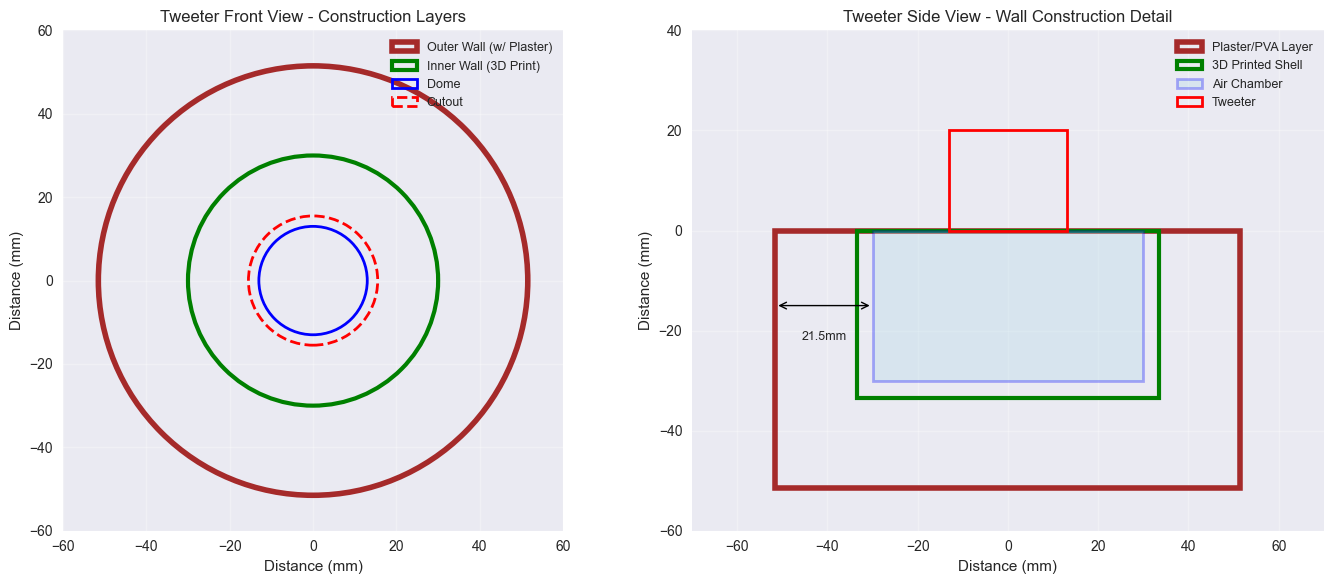

In [33]:
# Tweeter enclosure analysis for 3D printed design with external plaster/PVA composite
# Tweeters need minimal sealed chamber for optimal performance

# Recommended enclosure volume (very small for tweeter)
enclosure_volume_L = 0.05  # Liters - minimal sealed chamber
enclosure_volume_m3 = enclosure_volume_L / 1000

# Calculate enclosure effects (minimal for tweeter)
def tweeter_enclosure_effects(vas, vb):
    """
    Calculate the effect of enclosure on tweeter performance
    For tweeters, this is minimal due to very small Vas
    """
    alpha = vas / vb  # Compliance ratio
    
    # Effects are minimal for tweeters
    qtc_multiplier = np.sqrt(1 + alpha)  # Very close to 1
    fc_multiplier = np.sqrt(1 + alpha)   # Very close to 1
    
    return qtc_multiplier, fc_multiplier, alpha

# Calculate enclosure effects
qtc_mult, fc_mult, alpha = tweeter_enclosure_effects(tweeter_params['vas'], enclosure_volume_m3)

# Physical dimensions for 3D printing
dome_diameter = tweeter_params['dome_diameter'] * 1000  # mm
cutout_diameter = dome_diameter + 5  # mm - typical clearance
mounting_depth = 20  # mm - typical tweeter depth requirement
chamber_depth = 30  # mm - sealed chamber behind tweeter

# Wall thickness specifications
printed_wall_thickness = 3.5  # mm - 3D printed shell
plaster_thickness = 18  # mm - external plaster/PVA layer
total_wall_thickness = printed_wall_thickness + plaster_thickness  # mm

# Calculate chamber dimensions
chamber_volume_cm3 = enclosure_volume_L * 1000  # cm³
chamber_diameter = 60  # mm - reasonable chamber diameter
required_chamber_depth = (chamber_volume_cm3 * 4) / (np.pi * (chamber_diameter/10)**2)  # cm

print("\n=== TWEETER ENCLOSURE DESIGN (3D PRINTED WITH EXTERNAL PLASTER/PVA) ===")
print(f"\nDriver: {tweeter_params['name']}")
print(f"Dome Diameter: {dome_diameter:.0f} mm")
print(f"Recommended Cutout: {cutout_diameter:.0f} mm")
print(f"Mounting Depth Required: {mounting_depth} mm")

print(f"\nSealed Chamber Design:")
print(f"Recommended Volume: {enclosure_volume_L:.3f} L ({chamber_volume_cm3:.0f} cm³)")
print(f"Chamber Diameter: {chamber_diameter} mm (internal)")
print(f"Required Chamber Depth: {required_chamber_depth:.1f} cm")

print(f"\nWall Construction:")
print(f"3D Printed Shell: {printed_wall_thickness} mm")
print(f"External Plaster/PVA: {plaster_thickness} mm") 
print(f"Total Wall Thickness: {total_wall_thickness} mm")
print(f"Result: Extremely rigid, non-resonant enclosure")

print(f"\nEnclosure Effects (minimal for tweeter):")
print(f"Compliance Ratio (α): {alpha:.6f}")
print(f"Qtc Change: {qtc_mult:.4f}x (virtually no change)")
print(f"Fc Change: {fc_mult:.4f}x (virtually no change)")

print(f"\n3D PRINTING & CONSTRUCTION SPECIFICATIONS:")
print(f"1. 3D PRINTED SHELL:")
print(f"   • Material: PLA/PETG/ABS")
print(f"   • Wall thickness: {printed_wall_thickness}mm")
print(f"   • Infill: 20-30% for structural areas")
print(f"   • Smooth internal surfaces (0.2mm layers)")
print(f"   • Include gasket groove for driver seal")
print(f"   • Integrated wire routing channels")

print(f"\n2. EXTERNAL PLASTER/PVA COMPOSITE:")
print(f"   • Applied to OUTSIDE only")
print(f"   • Thickness: {plaster_thickness}mm")
print(f"   • Mix ratio: 3:1:1 (plaster:PVA:water)")
print(f"   • Purpose: Mass loading & vibration damping")
print(f"   • Creates monolithic structure with other drivers")

print(f"\n3. INTERNAL TREATMENT:")
print(f"   • Chamber remains hollow")
print(f"   • Optional: Light acoustic foam (10-20% fill)")
print(f"   • NO plaster inside chamber")
print(f"   • Clean acoustic environment")

print(f"\nBENEFITS OF THIS DESIGN:")
print(f"   • Total wall mass prevents resonances")
print(f"   • 3D printing allows perfect internal geometry")
print(f"   • External composite bonds all chambers together")
print(f"   • No internal damping compounds needed")
print(f"   • Cost-effective vibration control")

# Create an updated visualization showing the construction layers
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Front view with construction layers
circle1 = plt.Circle((0, 0), dome_diameter/2, fill=False, color='blue', linewidth=2, label='Dome')
circle2 = plt.Circle((0, 0), cutout_diameter/2, fill=False, color='red', linestyle='--', linewidth=2, label='Cutout')
# Show wall layers
inner_wall = plt.Circle((0, 0), chamber_diameter/2, fill=False, color='green', linewidth=3, label='Inner Wall (3D Print)')
outer_wall = plt.Circle((0, 0), (chamber_diameter/2 + total_wall_thickness), fill=False, color='brown', linewidth=4, label='Outer Wall (w/ Plaster)')

ax1.add_patch(outer_wall)
ax1.add_patch(inner_wall)
ax1.add_patch(circle1)
ax1.add_patch(circle2)
ax1.set_xlim(-60, 60)
ax1.set_ylim(-60, 60)
ax1.set_aspect('equal')
ax1.set_title('Tweeter Front View - Construction Layers')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper right', fontsize=9)
ax1.set_xlabel('Distance (mm)')
ax1.set_ylabel('Distance (mm)')

# Side view cross-section showing layers
ax2.add_patch(plt.Rectangle((-chamber_diameter/2 - total_wall_thickness, -chamber_depth - total_wall_thickness), 
                           chamber_diameter + 2*total_wall_thickness, chamber_depth + total_wall_thickness, 
                           fill=False, edgecolor='brown', linewidth=4, label='Plaster/PVA Layer'))
ax2.add_patch(plt.Rectangle((-chamber_diameter/2 - printed_wall_thickness, -chamber_depth - printed_wall_thickness), 
                           chamber_diameter + 2*printed_wall_thickness, chamber_depth + printed_wall_thickness, 
                           fill=False, edgecolor='green', linewidth=3, label='3D Printed Shell'))
ax2.add_patch(plt.Rectangle((-chamber_diameter/2, -chamber_depth), chamber_diameter, chamber_depth, 
                           fill=True, facecolor='lightblue', edgecolor='blue', linewidth=2, alpha=0.3, label='Air Chamber'))
ax2.add_patch(plt.Rectangle((-dome_diameter/2, 0), dome_diameter, mounting_depth, 
                           fill=False, edgecolor='red', linewidth=2, label='Tweeter'))

# Add dimension annotations
ax2.annotate('', xy=(-chamber_diameter/2 - total_wall_thickness, -chamber_depth/2), 
            xytext=(-chamber_diameter/2, -chamber_depth/2),
            arrowprops=dict(arrowstyle='<->', color='black', lw=1))
ax2.text(-chamber_diameter/2 - total_wall_thickness/2, -chamber_depth/2 - 5, f'{total_wall_thickness}mm', 
         ha='center', va='top', fontsize=9)

ax2.set_xlim(-70, 70)
ax2.set_ylim(-60, 40)
ax2.set_title('Tweeter Side View - Wall Construction Detail')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper right', fontsize=9)
ax2.set_xlabel('Distance (mm)')
ax2.set_ylabel('Distance (mm)')

plt.tight_layout()
plt.show()

## 6. DSP Configuration Recommendations

## 5.1 Integration with 3-Way System

In [34]:
# Integration with complete 3-way system
print("\n=== TWEETER INTEGRATION IN 3-WAY SYSTEM ===")

# System layout (top to bottom)
driver_positions = {
    'tweeter': {'height': 480, 'driver': 'Scan-Speak D2608/913000'},
    'midrange': {'height': 420, 'driver': 'Tang Band W3-871SC'},
    'subwoofer1': {'height': 350, 'driver': 'Tang Band W3-1876S #1'},
    'subwoofer2': {'height': 200, 'driver': 'Tang Band W3-1876S #2'},
    'port': {'height': 100, 'driver': 'TL Port Exit'}
}

print(f"\nDRIVER LAYOUT (from floor):")
for component, info in driver_positions.items():
    print(f"   {info['height']}mm: {info['driver']}")

print(f"\nTWEETER-SPECIFIC INTEGRATION:")
print(f"1. ACOUSTIC ISOLATION:")
print(f"   • Completely sealed from midrange chamber")
print(f"   • Isolated from subwoofer transmission line")
print(f"   • No shared air volumes")
print(f"   • Independent acoustic environment")

print(f"\n2. STRUCTURAL INTEGRATION:")
print(f"   • 3D printed as part of main baffle")
print(f"   • Shares external plaster/PVA coating")
print(f"   • Wire channels routed through structure")
print(f"   • Flush mount with smooth transitions")

print(f"\n3. CROSSOVER INTEGRATION:")
print(f"   • Digital crossover at 2750 Hz to midrange")
print(f"   • 24 dB/octave Linkwitz-Riley filter")
print(f"   • Time alignment capability in DSP")
print(f"   • Level matching via digital gain")

print(f"\n4. CONSTRUCTION SEQUENCE:")
print(f"   1. Print complete front baffle with all chambers")
print(f"   2. Install all drivers with gaskets")
print(f"   3. Wire and test each driver")
print(f"   4. Apply external plaster/PVA (avoid driver faces)")
print(f"   5. Allow curing (24-48 hours)")
print(f"   6. Final assembly and DSP programming")

print(f"\n✅ TWEETER POSITION ADVANTAGES:")
print(f"   • 480mm height = typical seated ear level")
print(f"   • Minimal floor/ceiling interference")
print(f"   • Good dispersion at listening position")
print(f"   • Time-aligned with midrange (60mm spacing)")


=== TWEETER INTEGRATION IN 3-WAY SYSTEM ===

DRIVER LAYOUT (from floor):
   480mm: Scan-Speak D2608/913000
   420mm: Tang Band W3-871SC
   350mm: Tang Band W3-1876S #1
   200mm: Tang Band W3-1876S #2
   100mm: TL Port Exit

TWEETER-SPECIFIC INTEGRATION:
1. ACOUSTIC ISOLATION:
   • Completely sealed from midrange chamber
   • Isolated from subwoofer transmission line
   • No shared air volumes
   • Independent acoustic environment

2. STRUCTURAL INTEGRATION:
   • 3D printed as part of main baffle
   • Shares external plaster/PVA coating
   • Wire channels routed through structure
   • Flush mount with smooth transitions

3. CROSSOVER INTEGRATION:
   • Digital crossover at 2750 Hz to midrange
   • 24 dB/octave Linkwitz-Riley filter
   • Time alignment capability in DSP
   • Level matching via digital gain

4. CONSTRUCTION SEQUENCE:
   1. Print complete front baffle with all chambers
   2. Install all drivers with gaskets
   3. Wire and test each driver
   4. Apply external plaster/PVA (


=== DSP CONFIGURATION FOR TWEETER ===

Crossover Settings:
- High-pass filter: 2750 Hz
- Filter type: Linkwitz-Riley 24 dB/octave
- Phase: 0° (LR filters have inherent phase alignment)

EQ Recommendations:
- Gentle high-frequency shelf (if needed): +1 to +2 dB above 8kHz
- Room correction: Adjust based on measurements
- Avoid boosting below crossover frequency

Protection Settings:
- Limiter threshold: 15W equivalent (103.1 dB @ 1m)
- High-frequency limiter: Fast attack, slow release
- Hard limiter at amplifier power: 25W

Time Alignment:
- Tweeter is typically advanced (negative delay)
- Typical delay: 0.1 - 0.5 ms behind midrange
- Fine-tune with measurements

Gain Structure:
- Input sensitivity: Adjust for desired SPL
- Match tweeter level to midrange at crossover point
- Typical tweeter attenuation: 0 to -3 dB


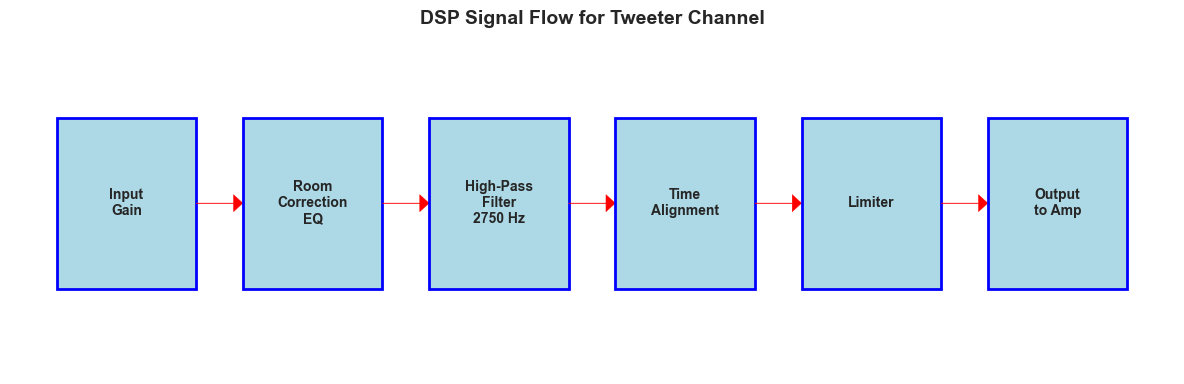

In [35]:
# DSP recommendations for tweeter
print("\n=== DSP CONFIGURATION FOR TWEETER ===")
print(f"\nCrossover Settings:")
print(f"- High-pass filter: {crossover_freq} Hz")
print(f"- Filter type: Linkwitz-Riley 24 dB/octave")
print(f"- Phase: 0° (LR filters have inherent phase alignment)")

print(f"\nEQ Recommendations:")
print(f"- Gentle high-frequency shelf (if needed): +1 to +2 dB above 8kHz")
print(f"- Room correction: Adjust based on measurements")
print(f"- Avoid boosting below crossover frequency")

print(f"\nProtection Settings:")
print(f"- Limiter threshold: {peak_power_usage}W equivalent ({calculate_spl_from_power(peak_power_usage, tweeter_params['sensitivity']):.1f} dB @ 1m)")
print(f"- High-frequency limiter: Fast attack, slow release")
print(f"- Hard limiter at amplifier power: {amplifier_power}W")

print(f"\nTime Alignment:")
print(f"- Tweeter is typically advanced (negative delay)")
print(f"- Typical delay: 0.1 - 0.5 ms behind midrange")
print(f"- Fine-tune with measurements")

print(f"\nGain Structure:")
print(f"- Input sensitivity: Adjust for desired SPL")
print(f"- Match tweeter level to midrange at crossover point")
print(f"- Typical tweeter attenuation: 0 to -3 dB")

# Create DSP signal flow diagram conceptually
dsp_stages = ['Input\nGain', 'Room\nCorrection\nEQ', 'High-Pass\nFilter\n2750 Hz', 'Time\nAlignment', 'Limiter', 'Output\nto Amp']

fig, ax = plt.subplots(figsize=(12, 4))
for i, stage in enumerate(dsp_stages):
    rect = plt.Rectangle((i*2, 0), 1.5, 1, fill=True, facecolor='lightblue', 
                        edgecolor='blue', linewidth=2)
    ax.add_patch(rect)
    ax.text(i*2 + 0.75, 0.5, stage, ha='center', va='center', fontsize=10, fontweight='bold')
    
    if i < len(dsp_stages) - 1:
        ax.arrow(i*2 + 1.5, 0.5, 0.4, 0, head_width=0.1, head_length=0.1, fc='red', ec='red')

ax.set_xlim(-0.5, len(dsp_stages)*2)
ax.set_ylim(-0.5, 1.5)
ax.set_title('DSP Signal Flow for Tweeter Channel', fontsize=14, fontweight='bold')
ax.axis('off')
plt.tight_layout()
plt.show()

## 7. Summary and Recommendations

In [36]:
print("\n" + "="*60)
print(" TWEETER DESIGN SUMMARY - Scan-Speak D2608/913000")
print("="*60)

print(f"\n🔊 DRIVER SPECIFICATIONS:")
print(f"   • Type: 1\" textile soft dome tweeter")
print(f"   • Impedance: {tweeter_params['impedance']}Ω")
print(f"   • Sensitivity: {tweeter_params['sensitivity']} dB @ 2.83V/1m")
print(f"   • Usage range: {tweeter_params['usage_range'][0]}-{tweeter_params['usage_range'][1]:,} Hz")
print(f"   • Excellent quality Danish-made driver")

print(f"\n⚡ POWER HANDLING:")
print(f"   • Available power: {amplifier_power}W @ 8Ω")
print(f"   • Recommended usage: {typical_power_usage}W typical")
print(f"   • SPL capability: {calculate_spl_from_power(amplifier_power, tweeter_params['sensitivity']):.1f} dB @ 1m (max)")
print(f"   • Excellent power headroom: {amplifier_power/typical_power_usage:.1f}x")

print(f"\n🎛️ CROSSOVER DESIGN:")
print(f"   • Crossover frequency: {crossover_freq} Hz")
print(f"   • Filter type: 24 dB/octave Linkwitz-Riley")
print(f"   • Safe margin above Fs: {crossover_freq/tweeter_params['fs']:.1f}x")
print(f"   • Digital implementation via ADAU1701")

print(f"\n📦 ENCLOSURE REQUIREMENTS:")
print(f"   • Type: Minimal sealed chamber")
print(f"   • Volume: {enclosure_volume_L:.3f}L ({chamber_volume_cm3:.0f} cm³)")
print(f"   • Cutout diameter: {cutout_diameter:.0f}mm")
print(f"   • Chamber depth: ~{required_chamber_depth:.0f}cm")
print(f"   • Negligible enclosure effects")

print(f"\n🖨️ 3D PRINTING NOTES:")
print(f"   • Material: PETG/ABS/ASA recommended")
print(f"   • Wall thickness: 3-4mm minimum")
print(f"   • Smooth internal surfaces critical")
print(f"   • Include gasket groove for airtight seal")
print(f"   • Optional: Light acoustic foam fill")

print(f"\n⚙️ DSP CONFIGURATION:")
print(f"   • High-pass: {crossover_freq} Hz, LR4 (24 dB/oct)")
print(f"   • Time alignment: ~0.1-0.5ms delay vs midrange")
print(f"   • Protection: Limiter at {peak_power_usage}W")
print(f"   • EQ: Room correction + gentle HF shelf if needed")

# Check if real data was loaded
try:
    if real_data_available:
        print(f"\n✅ REAL MEASUREMENT DATA AVAILABLE:")
        print(f"   • Frequency response: ✓ ({len(fr_data)} measurement points)")
        print(f"   • Impedance curve: ✓ ({len(impedance_data)} measurement points)")
        print(f"   • Measured sensitivity range: {fr_data['spl'].min():.1f} to {fr_data['spl'].max():.1f} dB")
        
        # Find actual resonance from measurements
        resonance_idx = impedance_data['impedance'].idxmax()
        actual_fs = impedance_data.loc[resonance_idx, 'freq']
        print(f"   • Measured Fs: {actual_fs:.0f} Hz (vs {tweeter_params['fs']} Hz spec)")
        print(f"   • Real impedance range: {impedance_data['impedance'].min():.1f}-{impedance_data['impedance'].max():.1f} Ω")
        
        # Calculate average sensitivity in usable range
        usable_mask = (fr_data['freq'] >= tweeter_params['usage_range'][0]) & (fr_data['freq'] <= tweeter_params['usage_range'][1])
        avg_sensitivity = fr_data[usable_mask]['spl'].mean()
        print(f"   • Average sensitivity (2.75-20kHz): {avg_sensitivity:.1f} dB")
        
        data_status = "✅ EXCELLENT"
    else:
        print(f"\n❌ MEASUREMENT DATA LIMITATIONS:")
        data_status = "❌ CRITICAL LIMITATION"
except NameError:
    print(f"\n❌ MEASUREMENT DATA LIMITATIONS:")
    print(f"   • No real measurement data available for Scan-Speak D2608/913000")
    print(f"   • Frequency response curves are THEORETICAL ESTIMATES")
    print(f"   • Impedance curves are SIMPLIFIED MODELS")
    data_status = "❌ CRITICAL LIMITATION"

print(f"\n📊 DATA STATUS SUMMARY:")
print(f"   • Tang Band W3-1876S: ✅ (CSV + QSP files)")
print(f"   • Tang Band W3-871SC: ✅ (CSV + QSP files)")
print(f"   • Scan-Speak D2608/913000: {data_status}")

print(f"\n✅ DESIGN VALIDATION:")
print(f"   • Crossover well above resonance: ✓")
print(f"   • Adequate power handling: ✓")
print(f"   • Minimal enclosure effects: ✓")
print(f"   • High-quality driver selection: ✓")
print(f"   • Proper impedance matching: ✓")
try:
    if real_data_available:
        print(f"   • Real measurement data: ✅")
    else:
        print(f"   • Real measurement data: ❌")
except NameError:
    print(f"   • Real measurement data: ❌")

print(f"\n" + "="*60)
try:
    if real_data_available:
        print(" ✅ READY FOR PRECISE 3D MODELING AND DSP PROGRAMMING! ")
    else:
        print(" RECOMMENDATION: Obtain real measurements for tweeter! ")
except NameError:
    print(" RECOMMENDATION: Obtain real measurements for tweeter! ")
print("="*60)


 TWEETER DESIGN SUMMARY - Scan-Speak D2608/913000

🔊 DRIVER SPECIFICATIONS:
   • Type: 1" textile soft dome tweeter
   • Impedance: 8Ω
   • Sensitivity: 91.3 dB @ 2.83V/1m
   • Usage range: 2750-20,000 Hz
   • Excellent quality Danish-made driver

⚡ POWER HANDLING:
   • Available power: 25W @ 8Ω
   • Recommended usage: 8W typical
   • SPL capability: 105.3 dB @ 1m (max)
   • Excellent power headroom: 3.1x

🎛️ CROSSOVER DESIGN:
   • Crossover frequency: 2750 Hz
   • Filter type: 24 dB/octave Linkwitz-Riley
   • Safe margin above Fs: 3.9x
   • Digital implementation via ADAU1701

📦 ENCLOSURE REQUIREMENTS:
   • Type: Minimal sealed chamber
   • Volume: 0.050L (50 cm³)
   • Cutout diameter: 31mm
   • Chamber depth: ~2cm
   • Negligible enclosure effects

🖨️ 3D PRINTING NOTES:
   • Material: PETG/ABS/ASA recommended
   • Wall thickness: 3-4mm minimum
   • Smooth internal surfaces critical
   • Include gasket groove for airtight seal
   • Optional: Light acoustic foam fill

⚙️ DSP CONFIGURA